# NB 03: Evolutionary Context of Costly + Dispensable Genes

Test whether costly+dispensable genes are recent acquisitions by examining
ortholog breadth, singleton enrichment, gene length, orphan gene fraction,
and per-organism variation.

**Run locally** — uses `data/gene_quadrants.tsv` from NB01.

**Outputs**: 3 figures, statistical tests.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path

plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['savefig.bbox'] = 'tight'

DATA_DIR = Path('../data')
FIG_DIR = Path('../figures')
FIG_DIR.mkdir(exist_ok=True)

## 1. Load Data

In [2]:
# Gene quadrants from NB01
genes = pd.read_csv(DATA_DIR / 'gene_quadrants.tsv', sep='\t')
print(f"Gene quadrants: {len(genes):,} genes")

# Ortholog groups
og = pd.read_csv('../../essential_genome/data/all_ortholog_groups.csv')
print(f"Ortholog groups: {len(og):,} entries, {og['OG_id'].nunique():,} groups")

# Specific phenotypes
spec_pheno = pd.read_csv(
    '../../fitness_effects_conservation/data/specific_phenotypes.tsv',
    sep='\t'
)
print(f"Specific phenotypes: {len(spec_pheno):,} genes")

Gene quadrants: 142,190 genes
Ortholog groups: 179,237 entries, 17,222 groups
Specific phenotypes: 13,476 genes


## 2. Ortholog Breadth

For each gene, count how many organisms share its ortholog group.
Recent acquisitions should have narrower breadth.

In [3]:
# Compute ortholog group breadth (number of organisms per OG)
og_breadth = og.groupby('OG_id')['orgId'].nunique().reset_index()
og_breadth.columns = ['OG_id', 'og_breadth']
print(f"OG breadth range: {og_breadth['og_breadth'].min()} - {og_breadth['og_breadth'].max()}")
print(f"Mean OG breadth: {og_breadth['og_breadth'].mean():.1f}")

# Map genes to OG breadth
gene_og = og.merge(og_breadth, on='OG_id', how='left')

# Merge with quadrant data
# Note: og uses orgId + locusId but locusId format may differ
genes_og = genes.merge(
    gene_og[['orgId', 'locusId', 'OG_id', 'og_breadth']],
    on=['orgId', 'locusId'],
    how='left'
)
genes_og['has_og'] = genes_og['OG_id'].notna()
genes_og['is_orphan'] = ~genes_og['has_og']

print(f"\nGenes with OG assignment: {genes_og['has_og'].sum():,} ({genes_og['has_og'].mean()*100:.1f}%)")
print(f"Orphan genes (no OG): {genes_og['is_orphan'].sum():,} ({genes_og['is_orphan'].mean()*100:.1f}%)")

OG breadth range: 2 - 48
Mean OG breadth: 7.7



Genes with OG assignment: 118,245 (83.2%)
Orphan genes (no OG): 23,945 (16.8%)


In [4]:
# Ortholog breadth by quadrant
breadth_by_quad = genes_og.groupby('quadrant').agg(
    n_genes=('locusId', 'count'),
    pct_has_og=('has_og', 'mean'),
    mean_breadth=('og_breadth', 'mean'),
    median_breadth=('og_breadth', 'median'),
).reset_index()
breadth_by_quad['pct_has_og'] = (breadth_by_quad['pct_has_og'] * 100).round(1)

print("Ortholog breadth by quadrant:")
print(breadth_by_quad.to_string(index=False))

# Mann-Whitney: costly_dispensable vs costly_conserved breadth with effect size
cd_breadth = genes_og[genes_og['quadrant'] == 'costly_dispensable']['og_breadth'].dropna()
cc_breadth = genes_og[genes_og['quadrant'] == 'costly_conserved']['og_breadth'].dropna()
u_stat, mw_pval = stats.mannwhitneyu(cd_breadth, cc_breadth, alternative='less')
n1, n2 = len(cd_breadth), len(cc_breadth)
rank_biserial_breadth = 1 - (2 * u_stat) / (n1 * n2)
print(f"\nMann-Whitney (costly_dispensable < costly_conserved breadth):")
print(f"  CD median: {cd_breadth.median():.0f}, CC median: {cc_breadth.median():.0f}")
print(f"  U={u_stat:,.0f}, p={mw_pval:.4g}, rank-biserial r={rank_biserial_breadth:.3f}")

Ortholog breadth by quadrant:
           quadrant  n_genes  pct_has_og  mean_breadth  median_breadth
   costly_conserved    28017        86.9     27.432455            31.0
 costly_dispensable     5526        55.5     20.604757            15.0
  neutral_conserved    86761        88.6     25.977459            28.0
neutral_dispensable    21886        63.7     19.111478            12.0

Mann-Whitney (costly_dispensable < costly_conserved breadth):
  CD median: 15, CC median: 31
  U=28,658,202, p=4.019e-99, rank-biserial r=0.233


/tmp/ipykernel_37102/1503491180.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data, labels=[q.replace('_', '\n') for q in quad_order],


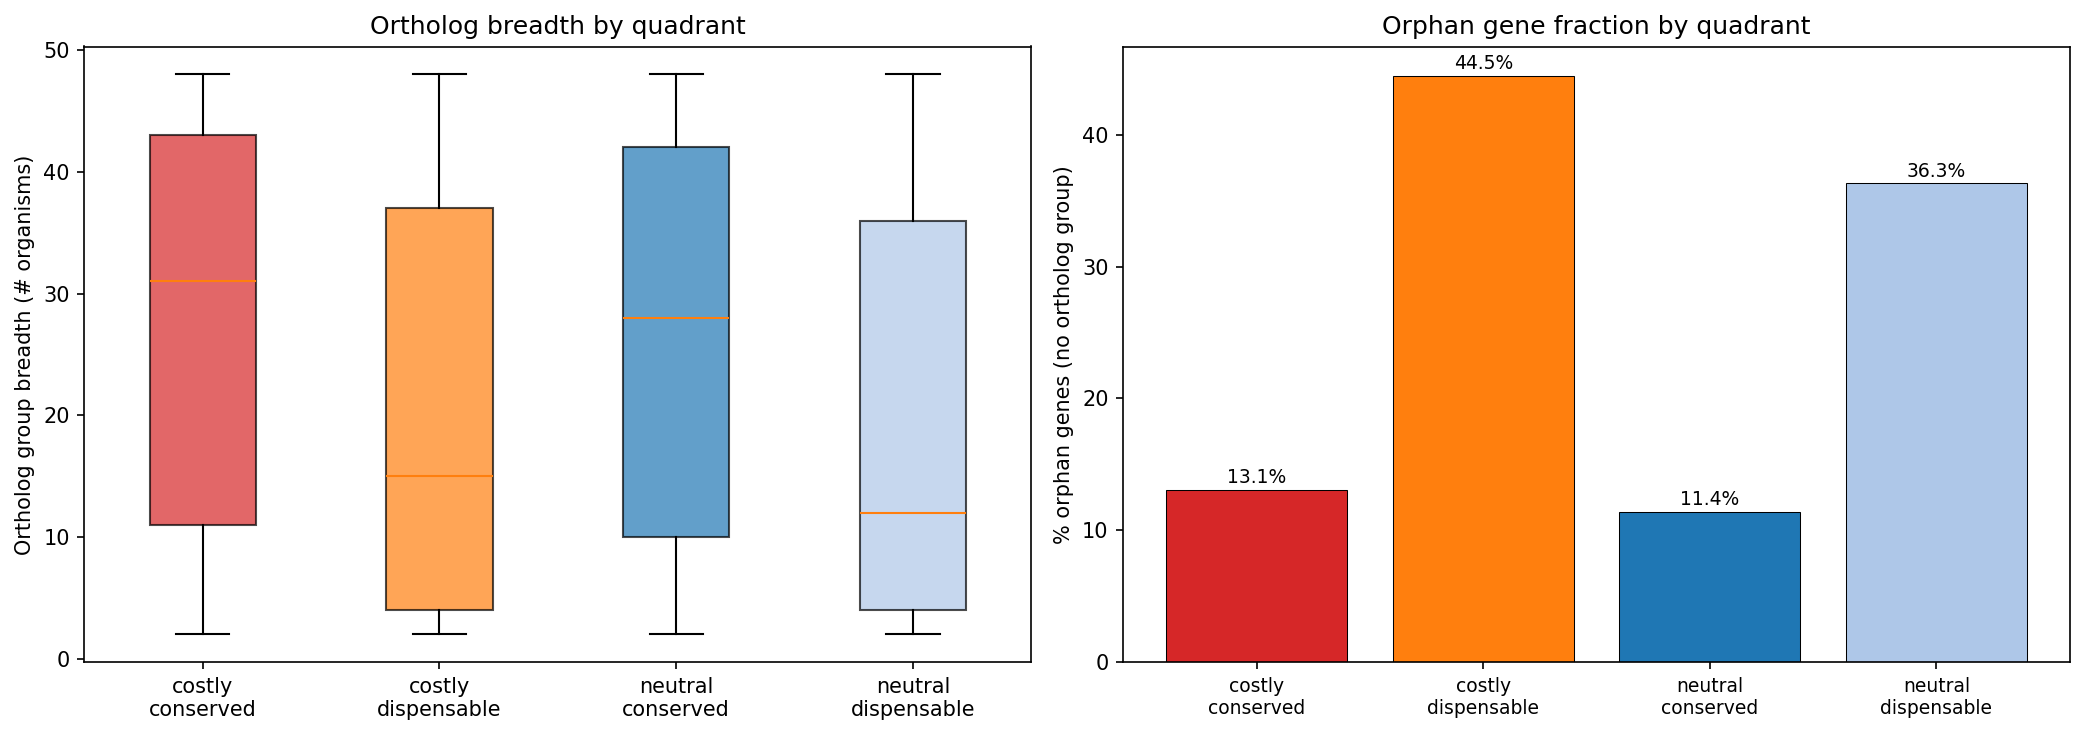

In [5]:
# Figure 1: Ortholog breadth distribution by quadrant
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

quad_order = ['costly_conserved', 'costly_dispensable', 'neutral_conserved', 'neutral_dispensable']
quad_colors = {'costly_conserved': '#d62728', 'costly_dispensable': '#ff7f0e',
               'neutral_conserved': '#1f77b4', 'neutral_dispensable': '#aec7e8'}

# Panel A: Box plot of OG breadth
ax = axes[0]
box_data = [genes_og[genes_og['quadrant'] == q]['og_breadth'].dropna().values for q in quad_order]
bp = ax.boxplot(box_data, labels=[q.replace('_', '\n') for q in quad_order],
                patch_artist=True, showfliers=False)
for patch, q in zip(bp['boxes'], quad_order):
    patch.set_facecolor(quad_colors[q])
    patch.set_alpha(0.7)
ax.set_ylabel('Ortholog group breadth (# organisms)')
ax.set_title('Ortholog breadth by quadrant')

# Panel B: Orphan gene fraction
ax = axes[1]
orphan_pct = [genes_og[genes_og['quadrant'] == q]['is_orphan'].mean() * 100 for q in quad_order]
bars = ax.bar(range(len(quad_order)), orphan_pct,
              color=[quad_colors[q] for q in quad_order],
              edgecolor='black', linewidth=0.5)
for i, pct in enumerate(orphan_pct):
    ax.text(i, pct + 0.5, f'{pct:.1f}%', ha='center', fontsize=9)
ax.set_xticks(range(len(quad_order)))
ax.set_xticklabels([q.replace('_', '\n') for q in quad_order], fontsize=9)
ax.set_ylabel('% orphan genes (no ortholog group)')
ax.set_title('Orphan gene fraction by quadrant')

plt.tight_layout()
plt.savefig(FIG_DIR / 'fig_ortholog_breadth.png')
plt.show()

## 3. Singleton Enrichment and Gene Length

In [6]:
# Singleton fraction by quadrant
singleton_by_quad = genes.groupby('quadrant')['is_singleton'].mean() * 100
print("Singleton fraction by quadrant:")
for q in quad_order:
    print(f"  {q:25s}: {singleton_by_quad.get(q, 0):.1f}%")

# Fisher exact: singleton enrichment in costly_dispensable vs costly_conserved
cd = genes[genes['quadrant'] == 'costly_dispensable']
cc = genes[genes['quadrant'] == 'costly_conserved']
table = [
    [cd['is_singleton'].sum(), (~cd['is_singleton']).sum()],
    [cc['is_singleton'].sum(), (~cc['is_singleton']).sum()]
]
odds_sing, pval_sing = stats.fisher_exact(table)
print(f"\nSingleton enrichment (CD vs CC): OR={odds_sing:.2f}, p={pval_sing:.4g}")
print("  NOTE: This is structurally determined -- core genes cannot be singletons")
print("  by definition, so all singletons are in the dispensable quadrants.")

# More informative: singletons in costly vs neutral DISPENSABLE
cd_disp = genes[genes['quadrant'] == 'costly_dispensable']
nd_disp = genes[genes['quadrant'] == 'neutral_dispensable']
table2 = [
    [cd_disp['is_singleton'].sum(), (~cd_disp['is_singleton']).sum()],
    [nd_disp['is_singleton'].sum(), (~nd_disp['is_singleton']).sum()]
]
odds_sing2, pval_sing2 = stats.fisher_exact(table2)
print(f"\nSingleton enrichment (costly vs neutral DISPENSABLE): OR={odds_sing2:.2f}, p={pval_sing2:.4g}")

# Gene length by quadrant
print("\nGene length by quadrant:")
length_by_quad = genes.groupby('quadrant')['gene_length'].agg(['mean', 'median'])
print(length_by_quad.round(0).to_string())

# Mann-Whitney: gene length with rank-biserial correlation as effect size
cd_len = genes[genes['quadrant'] == 'costly_dispensable']['gene_length'].dropna()
cc_len = genes[genes['quadrant'] == 'costly_conserved']['gene_length'].dropna()
u_stat, len_pval = stats.mannwhitneyu(cd_len, cc_len, alternative='less')
# Rank-biserial correlation: r = 1 - 2U/(n1*n2)
n1, n2 = len(cd_len), len(cc_len)
rank_biserial = 1 - (2 * u_stat) / (n1 * n2)
print(f"\nMann-Whitney (CD shorter than CC):")
print(f"  CD median: {cd_len.median():.0f}, CC median: {cc_len.median():.0f}")
print(f"  U={u_stat:,.0f}, p={len_pval:.4g}, rank-biserial r={rank_biserial:.3f}")

Singleton fraction by quadrant:
  costly_conserved         : 0.0%
  costly_dispensable       : 24.2%
  neutral_conserved        : 0.0%
  neutral_dispensable      : 22.7%

Singleton enrichment (CD vs CC): OR=inf, p=0
  NOTE: This is structurally determined -- core genes cannot be singletons
  by definition, so all singletons are in the dispensable quadrants.

Singleton enrichment (costly vs neutral DISPENSABLE): OR=1.09, p=0.02009

Gene length by quadrant:
                       mean  median
quadrant                           
costly_conserved      888.0   765.0
costly_dispensable    792.0   615.0
neutral_conserved    1072.0   933.0
neutral_dispensable  1112.0   906.0

Mann-Whitney (CD shorter than CC):
  CD median: 615, CC median: 765
  U=45,485,101, p=4.212e-75, rank-biserial r=0.170


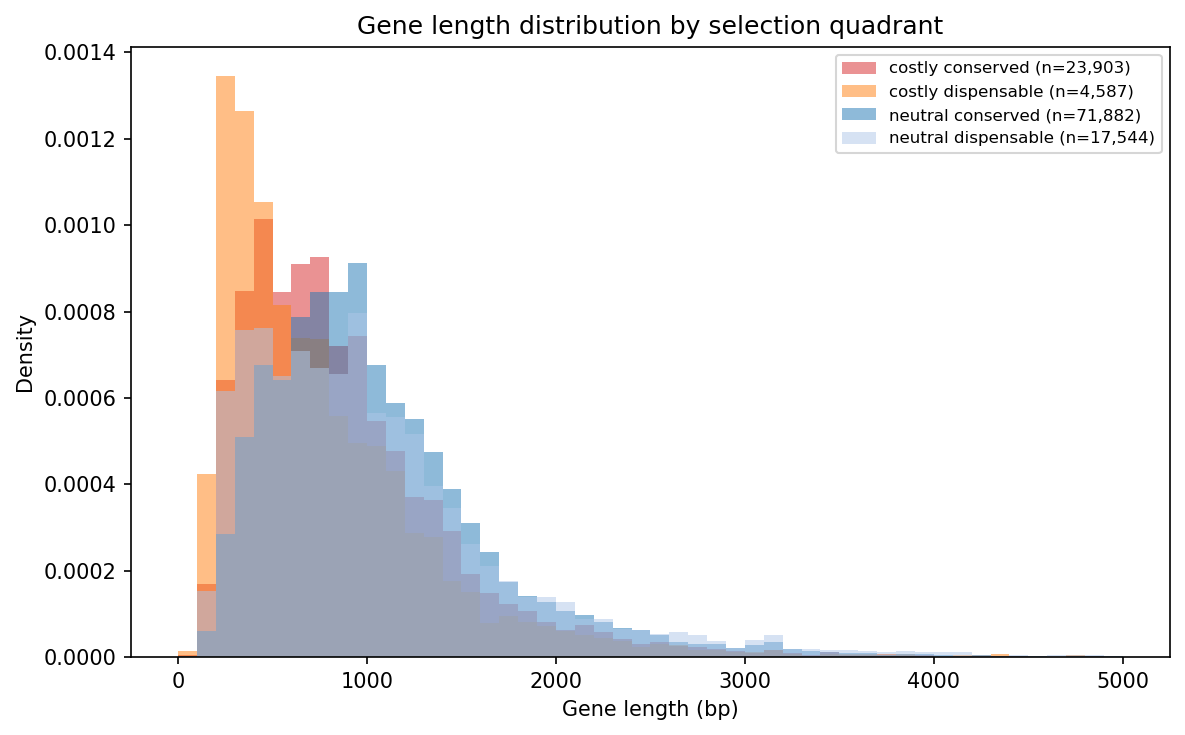

In [7]:
# Figure 2: Gene length distributions by quadrant
fig, ax = plt.subplots(figsize=(8, 5))

for q in quad_order:
    subset = genes[genes['quadrant'] == q]['gene_length'].dropna()
    ax.hist(subset, bins=50, alpha=0.5, label=f"{q.replace('_', ' ')} (n={len(subset):,})",
            color=quad_colors[q], density=True, range=(0, 5000))

ax.set_xlabel('Gene length (bp)')
ax.set_ylabel('Density')
ax.set_title('Gene length distribution by selection quadrant')
ax.legend(fontsize=8)

plt.tight_layout()
plt.savefig(FIG_DIR / 'fig_gene_length.png')
plt.show()

## 4. Specific Phenotype Analysis

In [8]:
# Merge specific phenotypes
genes_sp = genes.merge(spec_pheno, on=['orgId', 'locusId'], how='left')
genes_sp['n_specific_phenotypes'] = genes_sp['n_specific_phenotypes'].fillna(0).astype(int)
genes_sp['has_specific'] = genes_sp['n_specific_phenotypes'] > 0

sp_by_quad = genes_sp.groupby('quadrant').agg(
    pct_has_specific=('has_specific', 'mean'),
    mean_n_specific=('n_specific_phenotypes', 'mean'),
).reset_index()
sp_by_quad['pct_has_specific'] = (sp_by_quad['pct_has_specific'] * 100).round(1)

print("Specific phenotype prevalence by quadrant:")
print(sp_by_quad.to_string(index=False))

Specific phenotype prevalence by quadrant:
           quadrant  pct_has_specific  mean_n_specific
   costly_conserved              16.7         0.465110
 costly_dispensable              14.1         0.372964
  neutral_conserved               6.6         0.165558
neutral_dispensable               2.7         0.062232


## 5. Per-Organism Quadrant Proportions

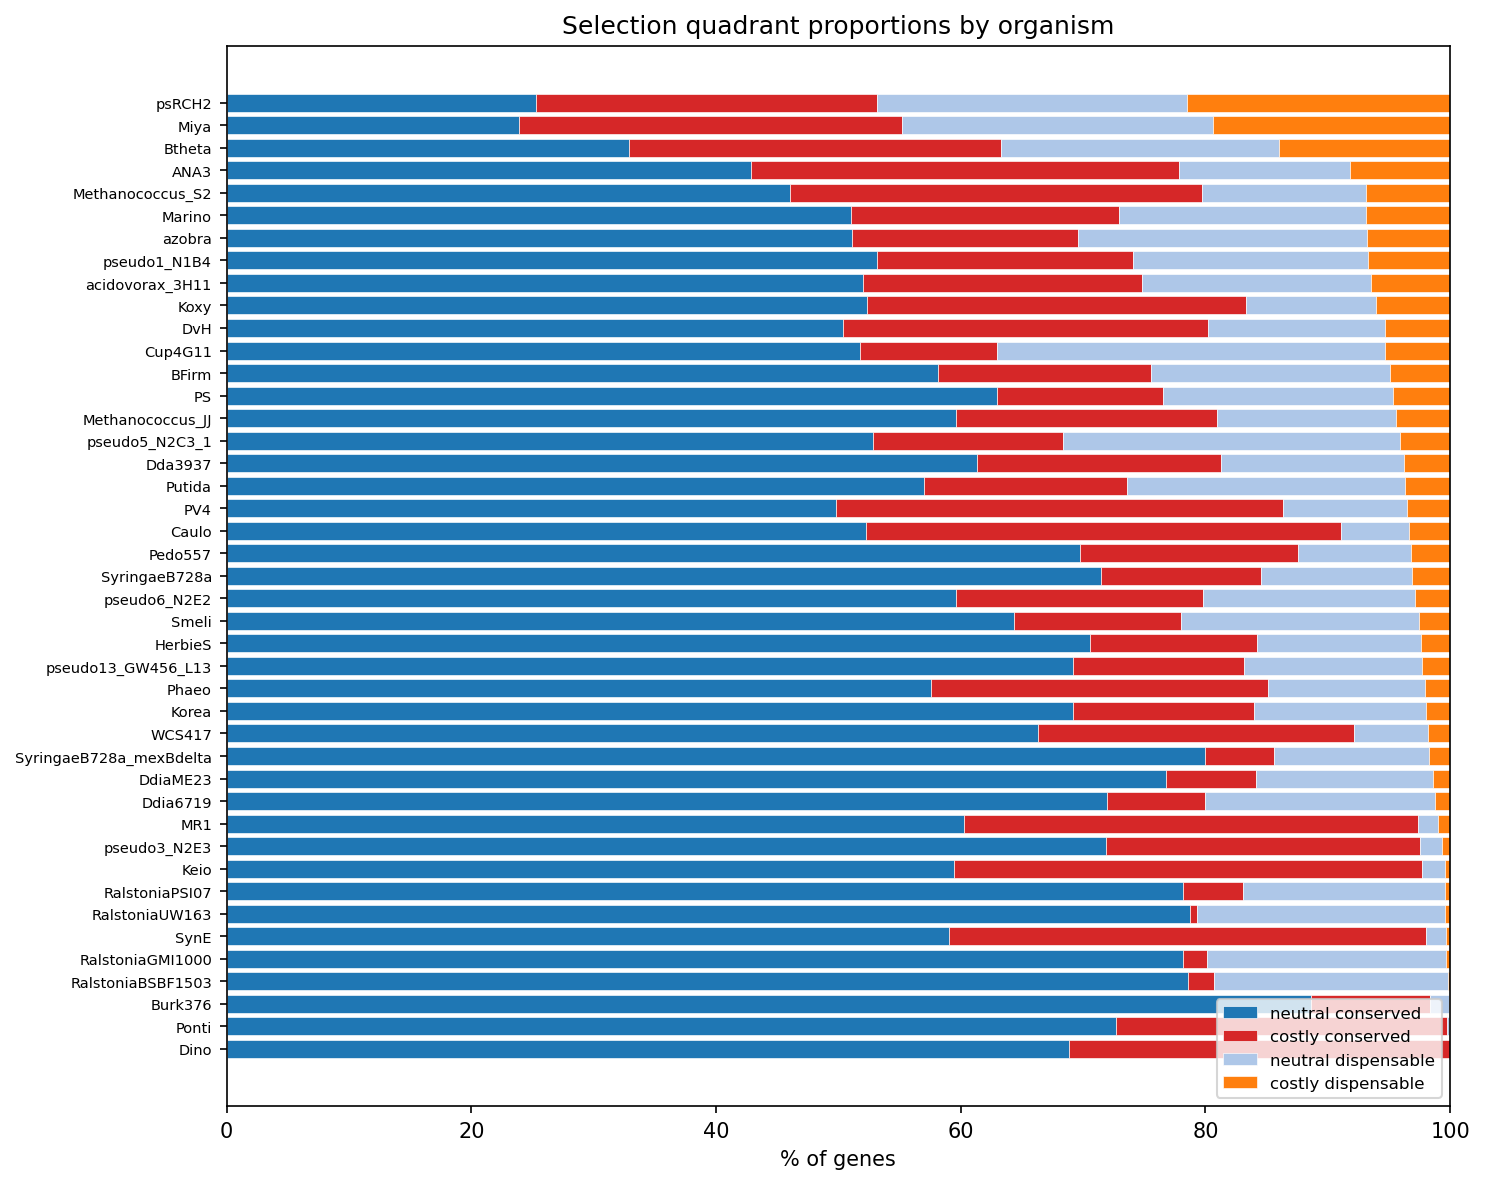

In [9]:
# Per-organism quadrant proportions
org_quads = genes.groupby(['orgId', 'quadrant']).size().unstack(fill_value=0)
org_totals = org_quads.sum(axis=1)
org_pcts = org_quads.div(org_totals, axis=0) * 100

# Sort by % costly+dispensable
org_pcts = org_pcts.sort_values('costly_dispensable', ascending=True)

# Figure 3: Stacked bar of quadrant proportions per organism
fig, ax = plt.subplots(figsize=(10, 8))

bottom = np.zeros(len(org_pcts))
for q in ['neutral_conserved', 'costly_conserved', 'neutral_dispensable', 'costly_dispensable']:
    if q in org_pcts.columns:
        vals = org_pcts[q].values
        ax.barh(range(len(org_pcts)), vals, left=bottom,
                label=q.replace('_', ' '), color=quad_colors[q],
                edgecolor='white', linewidth=0.3)
        bottom += vals

ax.set_yticks(range(len(org_pcts)))
ax.set_yticklabels(org_pcts.index, fontsize=7)
ax.set_xlabel('% of genes')
ax.set_title('Selection quadrant proportions by organism')
ax.legend(loc='lower right', fontsize=8)
ax.set_xlim(0, 100)

plt.tight_layout()
plt.savefig(FIG_DIR / 'fig_per_organism.png')
plt.show()

## 6. Summary

In [10]:
print("=" * 60)
print("NB03 SUMMARY: Evolutionary Context")
print("=" * 60)
print()
print("Ortholog breadth (costly_dispensable vs costly_conserved):")
print(f"  CD median: {cd_breadth.median():.0f}, CC median: {cc_breadth.median():.0f}")
print(f"  Mann-Whitney p={mw_pval:.4g}")
print()
print("Orphan gene fraction:")
for q in quad_order:
    pct = genes_og[genes_og['quadrant'] == q]['is_orphan'].mean() * 100
    print(f"  {q:25s}: {pct:.1f}%")
print()
print(f"Singleton enrichment (CD vs CC): OR={odds_sing:.2f}, p={pval_sing:.4g}")
print()
print(f"Gene length (CD vs CC): median {cd_len.median():.0f} vs {cc_len.median():.0f} bp")
print(f"  Mann-Whitney p={len_pval:.4g}")
print()
print("Specific phenotypes:")
for _, row in sp_by_quad.iterrows():
    print(f"  {row['quadrant']:25s}: {row['pct_has_specific']}% have specific phenotype")
print("=" * 60)

NB03 SUMMARY: Evolutionary Context

Ortholog breadth (costly_dispensable vs costly_conserved):
  CD median: 15, CC median: 31
  Mann-Whitney p=4.019e-99

Orphan gene fraction:
  costly_conserved         : 13.1%
  costly_dispensable       : 44.5%
  neutral_conserved        : 11.4%
  neutral_dispensable      : 36.3%

Singleton enrichment (CD vs CC): OR=inf, p=0

Gene length (CD vs CC): median 615 vs 765 bp
  Mann-Whitney p=4.212e-75

Specific phenotypes:
  costly_conserved         : 16.7% have specific phenotype
  costly_dispensable       : 14.1% have specific phenotype
  neutral_conserved        : 6.6% have specific phenotype
  neutral_dispensable      : 2.7% have specific phenotype
